In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [37]:
import tensorflow as tf

In [38]:
print(tf.__version__)

1.13.1


In [3]:
 #function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [9]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [10]:
deu_eng = deu_eng[:2000,:]

In [11]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['I never win.', 'Ich gewinne nie.'],
       ['I often ski.', 'Ich fahre oft Ski.'],
       ['I oppose it.', 'Ich bin dagegen.']], dtype='<U537')

In [12]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [13]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['I never win', 'Ich gewinne nie'],
       ['I often ski', 'Ich fahre oft Ski'],
       ['I oppose it', 'Ich bin dagegen']], dtype='<U537')

In [14]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [15]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['i never win', 'ich gewinne nie'],
       ['i often ski', 'ich fahre oft ski'],
       ['i oppose it', 'ich bin dagegen']], dtype='<U537')

Text to Sequence Conversion
To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [16]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [17]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

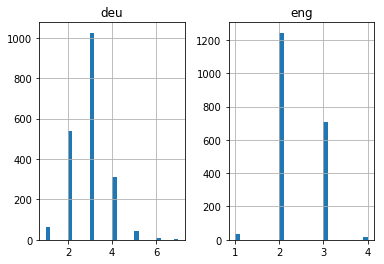

In [18]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 671


In [21]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 1148


In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Model Building
We will now split the data into train and test set for model training and evaluation, respectively.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [25]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [26]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


Please note that we have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using ModelCheckpoint() to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [28]:
filename = 'model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 [==============================] - 9s 7ms/step - loss: 6.2550 - val_loss: 2.4804

Epoch 00001: val_loss improved from inf to 2.48042, saving model to model.h1
Epoch 2/10
1280/1280 [==============================] - 3s 3ms/step - loss: 2.2683 - val_loss: 2.1014

Epoch 00002: val_loss improved from 2.48042 to 2.10144, saving model to model.h1
Epoch 3/10
1280/1280 [==============================] - 3s 3ms/step - loss: 1.9506 - val_loss: 1.9976

Epoch 00003: val_loss improved from 2.10144 to 1.99764, saving model to model.h1
Epoch 4/10
1280/1280 [==============================] - 5s 4ms/step - loss: 1.8469 - val_loss: 1.9438

Epoch 00004: val_loss improved from 1.99764 to 1.94381, saving model to model.h1
Epoch 5/10
1280/1280 [==============================] - 5s 4ms/step - loss: 1.7881 - val_loss: 

Make Predictions
Let's load the saved model to make predictions.

In [29]:
model = load_model('model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [30]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [31]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [33]:
pd.set_option('display.max_colwidth', 200)

In [34]:
pred_df.head(5)

,actual,predicted
0,kiss tom,i
1,let tom in,i
2,forget it,i
3,were lazy,i
4,i love snow,i


http://www.manythings.org/anki/